# Pb scavenging parameterization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import xarray as xr
import cmocean
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Parameters / settings:

In [163]:
land_color = '#a9a7a2'

# Domain dimensions:
imin, imax = 159, 799
jmin, jmax = 1099, 2179
isize = imax - imin
jsize = jmax - jmin

General files:

In [3]:
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'][0,:,:,:].values
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

In [4]:
# BLING:

folder_EPM101 = '/data/brogalla/ANHA4/BLING-EPM101/'
folder_EPM102 = '/data/brogalla/ANHA4/BLING-EPM102/'

dset = xr.open_dataset(f'{folder_EPM101}ANHA4-EPM101_y2002m08d13_gridB.nc')
ANHA4_lons = dset['nav_lon'].values
ANHA4_lats = dset['nav_lat'].values
ANHA4_depths = dset['deptht'].values

file_range = ['ANHA4-EPM101_y2002m08d18_gridB.nc', 'ANHA4-EPM101_y2002m08d23_gridB.nc', 'ANHA4-EPM101_y2002m08d28_gridB.nc', \
              'ANHA4-EPM101_y2002m09d02_gridB.nc', 'ANHA4-EPM101_y2002m09d07_gridB.nc', 'ANHA4-EPM101_y2002m09d12_gridB.nc', \
              'ANHA4-EPM101_y2002m09d17_gridB.nc', 'ANHA4-EPM101_y2002m09d22_gridB.nc', 'ANHA4-EPM101_y2002m09d27_gridB.nc', \
              'ANHA4-EPM101_y2002m10d02_gridB.nc', 'ANHA4-EPM101_y2002m10d07_gridB.nc']

biomass_p = np.zeros((50,800,544))
zflux_pop = np.zeros((50,800,544))
for n,file in enumerate(file_range):
    dset = xr.open_dataset(folder_EPM101+file)
    biomass_p = biomass_p + dset['biomass_p'][0,:,:,:].drop(labels=['time_centered', 'time_counter']).values
    zflux_pop = zflux_pop + dset['jp_pop'] [0,:,:,:].drop(labels=['time_centered', 'time_counter']).values
    
biomass = biomass_p / n
zflux   = zflux_pop / n 

In [6]:
# Mn for surface particle field:
dset_ANHA12 = xr.open_dataset('/data/brogalla/run_storage/Mn-extended-domain-202201/ANHA12_mn-extended-2015_20220127/'+
                              'ANHA12_EXH006_2015_monthly.nc')
# dset_ANHA12 = xr.open_dataset('/data/brogalla/run_storage/old/Mn-reference-202101/ref-2015-202101/ANHA12_EXH006_2015_monthly.nc')
ANHA12_lons = dset_ANHA12['nav_lon'].values
ANHA12_lats = dset_ANHA12['nav_lat'].values
ANHA12_Mn   = dset_ANHA12['dissolmn'][7,0,:,:,:].values
ANHA12_Mn[ANHA12_Mn < 0] = 0

Functions:

In [13]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate some field to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : input field lon/lat
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D model variable
    '''
    from scipy.interpolate import griddata
    
    LatLonPair = (nav_lon, nav_lat)
    var_out = griddata(LatLonPair, var_in, (lon_ANHA12, lat_ANHA12), method='linear')
    var_out[np.isnan(var_out)] = 0.0 # if that is still NaN, then set to zero.
    return var_out

In [14]:
def find_index_ANHA12(lons, lats, ANHA12_lon=ANHA12_lons, ANHA12_lat=ANHA12_lats):
    # input:   ANHA12_lons, ANHA12_lats     --- 700x640 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values
    # output:  i, j                         --- lists of coordinates associated with these points
    
    all_i = np.array([])
    all_j = np.array([])
    if isinstance(lons,float):
        i, j = ar.find_closest_model_point(lons, lats, ANHA12_lon, ANHA12_lat)
        all_i = i
        all_j = j
    else:
        for k in range(0,len(lons)):
            i, j = ar.find_closest_model_point(lons[k], lats[k], ANHA12_lon, ANHA12_lat)
            all_i = np.append(all_i, i)
            all_j = np.append(all_j, j)
    
    return all_i, all_j

In [183]:
def plot_residence_time(res_time, depth_slice=(0,18), maxv=1.0):
    res_time_slice = np.mean(res_time[depth_slice[0]:depth_slice[1],:,:], axis=0)
    
    fig, ax1 = plt.subplots(1,1,figsize=(4.5, 3.74), dpi=300)

    proj=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax1)
    proj.drawcoastlines(color='#373736', linewidth=1.0);
    proj.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
    
    x, y = proj(mesh_lon, mesh_lat)
#     proj.contourf(x, y, bathy_masked[depth_slice[1],:,:], colors=[land_color]) # Mask land at particular depth
    proj.contourf(x, y, bathy_masked[depth_slice[1],:,:], colors=[land_color]) # Mask land at particular depth
    
    # Domain boundaries: 
    proj.plot(x[jmin:1136,680]   , y[jmin:1136,680]    , '-', c='k', lw=1.0, zorder=5); # southeastern Greenland
    proj.plot(x[jmin,442:680]    , y[jmin,442:680]     , '-', c='k', lw=1.0, zorder=5); # southern Baffin Bay
    proj.plot(x[jmax,392:imax-1] , y[jmax,392:imax-1]  , '-', c='k', lw=1.0, zorder=5); # western Canada Basin
    proj.plot(x[1600:jmax,imax-1], y[1600:jmax,imax-1] , '-', c='k', lw=1.0, zorder=5); # northern Canada Basin
    proj.plot(x[1190:1474,292]   , y[1190:1474,292]    , '-', c='k', lw=1.0, zorder=5); # Hudson Bay bdy
    
    # Show Arctic Ocean observed residence times only if depth slice shown goes shallower than 60 m.
    if depth_slice[0] < 17:
        x_kadko, y_kadko = proj(kadko_lons, kadko_lats)
        x_chen,  y_chen  = proj(chen_lons, chen_lats)
        CB = proj.scatter(x_kadko, y_kadko, c=kadko_res, s=30, edgecolor='w', zorder=5, vmin=0, vmax=maxv, cmap=cmocean.cm.matter)
        proj.scatter(x_chen, y_chen, c=chen_res, s=30, edgecolor='w', zorder=5, vmin=0, vmax=maxv, cmap=cmocean.cm.matter)
        
        cbaxes1 = fig.add_axes([0.13, 0.17, 0.03, 0.23]) 
        CBar1 = plt.colorbar(CB, ax=ax1, cax=cbaxes1, orientation='vertical')
        CBar1.ax.tick_params(labelsize=6) 
        CBar1.set_label('Residence time [years]', fontsize=6)
        
    # Model residence time estimate:
    x_ANHA12, y_ANHA12 = proj(ANHA12_lons, ANHA12_lats)
#     CB2 = proj.contourf(x_ANHA12, y_ANHA12, res_time_slice, levels=np.linspace(0,maxv,21), cmap=cmocean.cm.matter, vmin=0, vmax=maxv, extend='both')

    CB2 = proj.pcolormesh(x_ANHA12, y_ANHA12, res_time_slice, cmap=cmocean.cm.matter, vmin=0, vmax=maxv)
        
    # Colorbar:
    cbaxes2 = fig.add_axes([0.25, 0.17, 0.03, 0.23]) 
    CBar2 = plt.colorbar(CB2, ax=ax1, cax=cbaxes2, orientation='vertical')
    CBar2.ax.tick_params(labelsize=6) 
    CBar2.set_label('Model residence time', fontsize=6)
    
    ax1.set_title(f'Depth slice: {depths[depth_slice[0]]:.0f}-{depths[depth_slice[1]]:.0f} m', fontsize=6)
    return

### Residence time estimates

Observations summary table: https://www.overleaf.com/read/pwyprcnqqscp

In [16]:
# Kadko et al., 2018: collected August 20 - October 5, 2015
kadko_lats   = np.array([76.511, 79.997, 83.755, 87.520, 88.407, 89.987, 87.815, 85.135, 82.491, 80.369, 78.180, 77.503, 76.998, \
                76.505, 73.506, 73.008])
kadko_lons   = np.array([-173.034, -174.962, 174.915, -179.809, -176.761, -89.25, -149.734, -150.063, -149.872, -149.855, -147.831, -148.009, -148.803, \
               -149.515, -156.808, -158.729])
kadko_depths = np.array([56, 52, 52, 46, 20, 23, 45, 41, 47, 49, 40, 47, 40, 40, 46, 36])
kadko_res    = np.array([0.69, 0.76, 0.94, 0.24, 0.76, 0.27, 0.33, 0.71, 1.07, 0.65, 0.31, 0.36, 0.41, 0.28, 0.38, 0.18])

In [17]:
# Chen et al., 2012: 
chen_lats   = np.array([69.996, 73.998, 68.919, 70.495, 71.579, 71.261, 73.995, 73.380])
chen_lons   = np.array([-168.999, -168.991, -167.009, -162.976, -164.013, -150.376, -156.332, -151.883])
chen_depths = np.array([30, 40, 10, 30, 40, 20, 30, 100])
chen_res    = np.array([0.05, 0.10, 0.01, 0.15, 0.03, 0.10, 0.23, 0.28])

In [18]:
kadko_ANHA12_i, kadko_ANHA12_j = find_index_ANHA12(kadko_lons, kadko_lats)
chen_ANHA12_i,  chen_ANHA12_j  = find_index_ANHA12(chen_lons, chen_lats)

### Particle estimates:

In [23]:
ANHA12_biomass = np.empty((50,1080,640))
for depth in range(0,50):
    ANHA12_biomass[depth,:,:] = interp_np(ANHA4_lons.flatten(), ANHA4_lats.flatten(), biomass[depth,:,:].flatten(), ANHA12_lons, ANHA12_lats)

In [24]:
# particles:
normalized_biogenic   = ANHA12_biomass/np.amax(ANHA12_biomass)
normalized_lithogenic = ANHA12_Mn/np.amax(ANHA12_Mn)

particle composition recipe: 
- $\beta$ --- lithogenic fraction
- $1-\beta$ --- biogenic fraction

In [25]:
betas     = np.linspace(0,1,40)
constants = np.linspace(1e-5,4e-2,20)
kadko_res_time_diff     = np.empty((len(kadko_res),len(constants),len(betas))); kadko_res_time_diff[:]     = np.nan;
kadko_modelled_res_time = np.empty((len(kadko_res),len(constants),len(betas))); kadko_modelled_res_time[:] = np.nan;
chen_res_time_diff      = np.empty((len(chen_res),len(constants),len(betas)));  chen_res_time_diff[:]      = np.nan;
chen_modelled_res_time  = np.empty((len(chen_res),len(constants),len(betas)));  chen_modelled_res_time[:]  = np.nan;

for ci,c in enumerate(constants):
    for bi, beta in enumerate(betas):
        # Residence time associated with these fractions
        res_time = c / ((1-beta)*normalized_biogenic + beta*normalized_lithogenic)

        # Difference between modeled and observed residence time at the stations:
        for n, stn in enumerate(zip(kadko_ANHA12_i, kadko_ANHA12_j)):
            if (~np.isnan(stn[0])) & (~np.isnan(stn[1])):
                stni = int(stn[0]); stnj = int(stn[1]);
                kadko_modelled_res_time[n,ci,bi] = np.mean(res_time[0:18,stni,stnj],axis=0) # mean over upper 50 m
                kadko_res_time_diff[n,ci,bi]     = kadko_res[n] - np.mean(res_time[0:18,stni,stnj],axis=0) # mean over upper 50 m
        
        
        for n, stn in enumerate(zip(chen_ANHA12_i, chen_ANHA12_j)):
            if (~np.isnan(stn[0])) & (~np.isnan(stn[1])):
                stni = int(stn[0]); stnj = int(stn[1]);
                chen_modelled_res_time[n,ci,bi] = np.mean(res_time[0:18,stni,stnj],axis=0) # mean over upper 50 m
                chen_res_time_diff[n,ci,bi]     = chen_res[n] - np.mean(res_time[0:18,stni,stnj],axis=0) # mean over upper 50 m

In [26]:
kadko_res_time_diff_mean = np.nanmean(kadko_res_time_diff, axis=0)
kadko_res_time_rms       = np.sum(kadko_res_time_diff**2, axis=0)/len(kadko_res)

chen_res_time_diff_mean = np.nanmean(chen_res_time_diff, axis=0)
chen_res_time_rms       = np.sum(chen_res_time_diff**2, axis=0)/len(chen_res)

# Plots

Mean simulated biomass during period of sampling is normalized (biogenic particles) and combined with normalized Mn model field (lithogenic particles) as a measure of particle abundance. Then the particle abundance is inversely related to the residence time. Free parameters are: constant of inverse proportionality, fraction biogenic vs. lithogenic.

In [27]:
colors = ['#f6c6bb', '#fa654a', '#e9bb65', '#78add6']

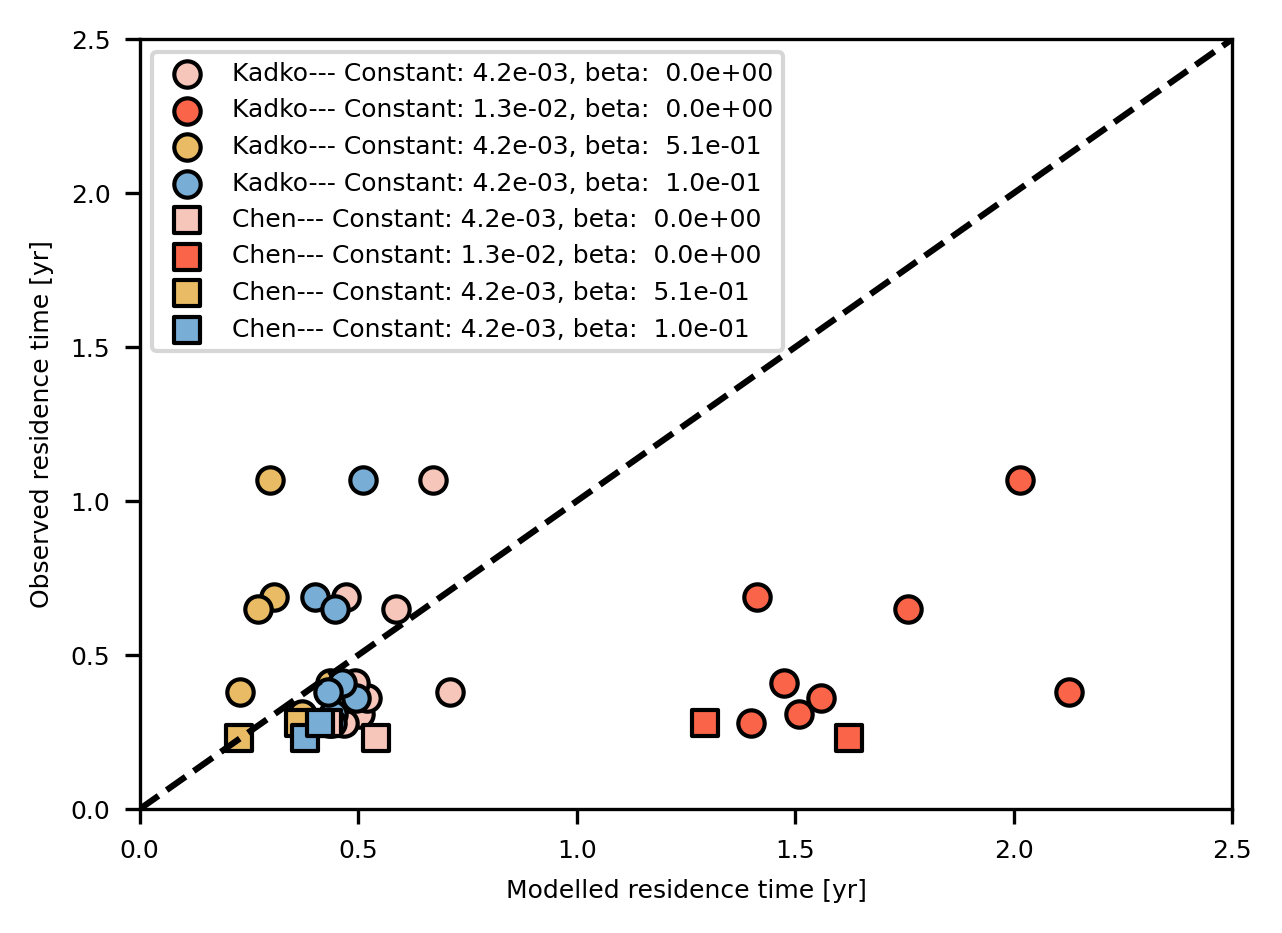

In [28]:
fig, ax = plt.subplots(1,1, figsize=(4.7,3.4), dpi=300)

ax.scatter(kadko_modelled_res_time[:,2,0],  kadko_res, color=colors[0], s=40, edgecolor='k', \
           label=f'Kadko--- Constant: {constants[2]:.1e}, beta:  {betas[0]:.1e}')
ax.scatter(kadko_modelled_res_time[:,6,0],  kadko_res, color=colors[1], s=40, edgecolor='k', \
           label=f'Kadko--- Constant: {constants[6]:.1e}, beta:  {betas[0]:.1e}')
ax.scatter(kadko_modelled_res_time[:,2,20], kadko_res, color=colors[2], s=40, edgecolor='k', \
           label=f'Kadko--- Constant: {constants[2]:.1e}, beta:  {betas[20]:.1e}')
ax.scatter(kadko_modelled_res_time[:,2,4],  kadko_res, color=colors[3], s=40, edgecolor='k', \
           label=f'Kadko--- Constant: {constants[2]:.1e}, beta:  {betas[4]:.1e}')

ax.scatter(chen_modelled_res_time[:,2,0],  chen_res, marker='s', color=colors[0], s=40, edgecolor='k', \
           label=f'Chen--- Constant: {constants[2]:.1e}, beta:  {betas[0]:.1e}')
ax.scatter(chen_modelled_res_time[:,6,0],  chen_res, marker='s', color=colors[1], s=40, edgecolor='k', \
           label=f'Chen--- Constant: {constants[6]:.1e}, beta:  {betas[0]:.1e}')
ax.scatter(chen_modelled_res_time[:,2,20], chen_res, marker='s', color=colors[2], s=40, edgecolor='k', \
           label=f'Chen--- Constant: {constants[2]:.1e}, beta:  {betas[20]:.1e}')
ax.scatter(chen_modelled_res_time[:,2,4],  chen_res, marker='s', color=colors[3], s=40, edgecolor='k', \
           label=f'Chen--- Constant: {constants[2]:.1e}, beta:  {betas[4]:.1e}')

ax.plot([0,3],[0,3], '--k')
ax.set_xlabel('Modelled residence time [yr]', fontsize=6)
ax.set_ylabel('Observed residence time [yr]', fontsize=6)
ax.set_xlim(0,2.5)
ax.set_ylim(0,2.5)
ax.tick_params(labelsize=6)
ax.legend(fontsize=6)

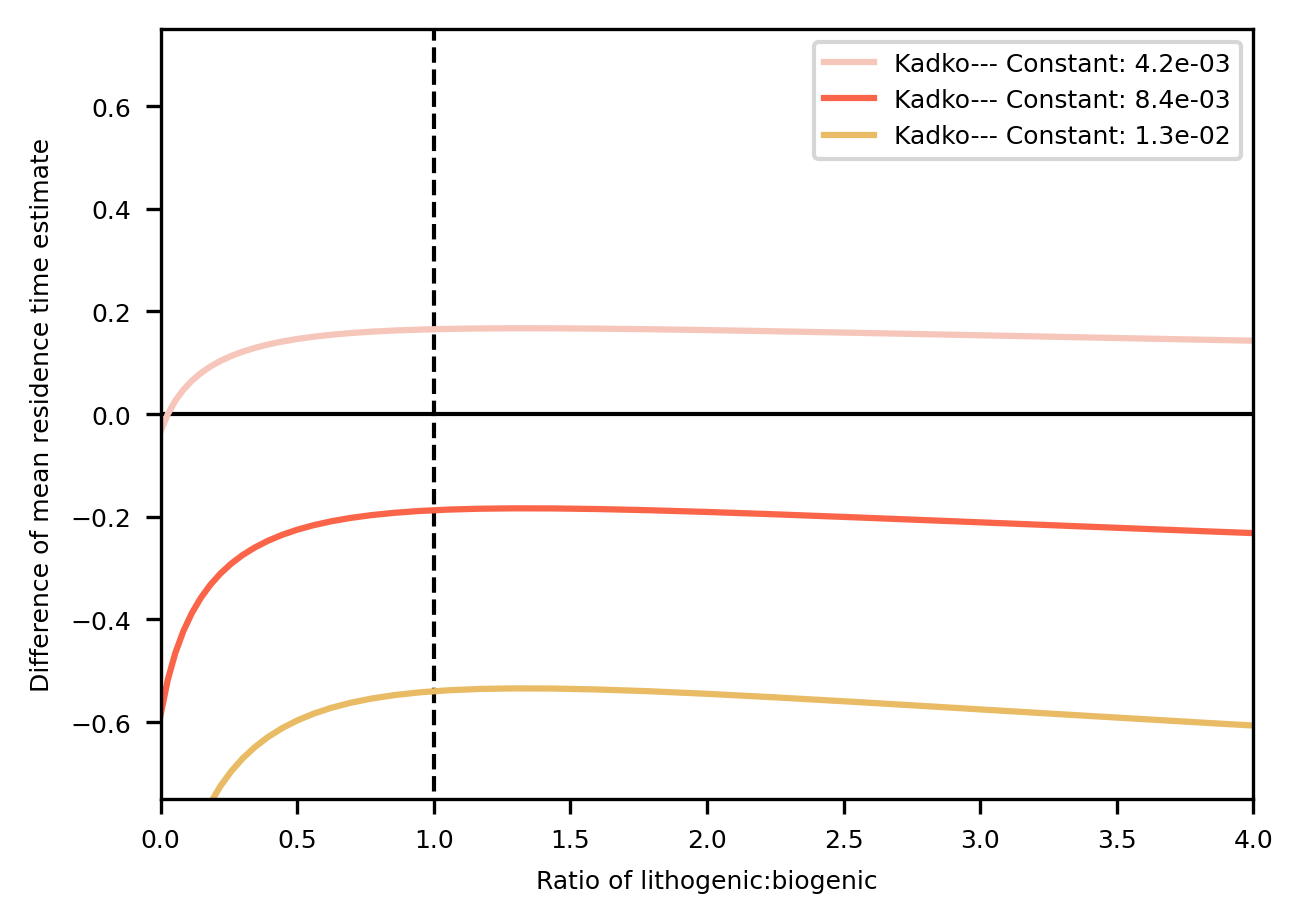

In [29]:
fig, ax = plt.subplots(1,1, figsize=(4.7,3.4), dpi=300)

ax.plot([1,1],[-2,2], '--k', linewidth=1.0)
ax.plot([0,5],[0,0], '-k', linewidth=1.0)
ax.plot(betas/(1-betas), kadko_res_time_diff_mean[2,:],'-', color=colors[0], label=f'Kadko--- Constant: {constants[2]:.1e}')
ax.plot(betas/(1-betas), kadko_res_time_diff_mean[4,:],'-', color=colors[1], label=f'Kadko--- Constant: {constants[4]:.1e}')
ax.plot(betas/(1-betas), kadko_res_time_diff_mean[6,:],'-', color=colors[2], label=f'Kadko--- Constant: {constants[6]:.1e}')
ax.set_xlabel('Ratio of lithogenic:biogenic', fontsize=6)
ax.set_ylabel('Difference of mean residence time estimate', fontsize=6)
ax.set_xlim(0,4)
ax.set_ylim(-0.75,0.75)
ax.tick_params(labelsize=6)
ax.legend(fontsize=6)

In [30]:
cif, bif = np.meshgrid(constants, betas/(1-betas))

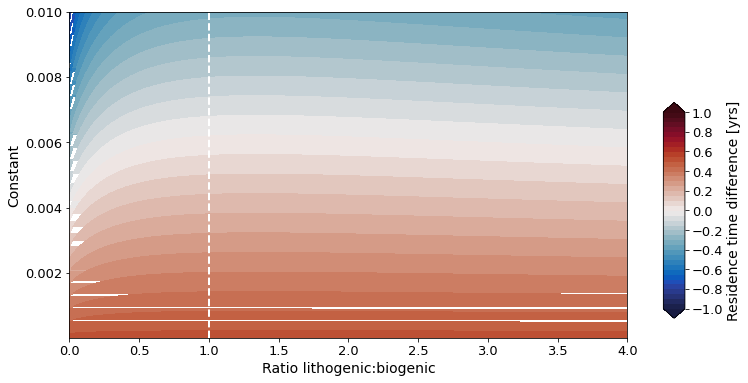

In [31]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

CB = ax.contourf(bif, cif, kadko_res_time_diff_mean.transpose(), \
                 levels=np.linspace(-1,1,41), cmap = cmocean.cm.balance, vmin=-1, vmax=1, extend='both')
ax.plot([1,1],[0,10],'--w', linewidth=2.0)
ax.set_xlabel('Ratio lithogenic:biogenic', fontsize=14)
ax.set_ylabel('Constant', fontsize=14)
ax.set_xlim(0,4)
ax.set_ylim(1e-5,1e-2)

# Colorbar:
ax.tick_params(labelsize=13)
cbaxes = fig.add_axes([0.95, 0.17, 0.03, 0.50]) 
CBar = plt.colorbar(CB, ax=ax, cax=cbaxes, orientation='vertical', ticks=np.arange(-1,1.2,0.2))
CBar.ax.tick_params(labelsize=13) 
CBar.set_label('Residence time difference [yrs]', fontsize=14)

In [86]:
print(np.mean(normalized_lithogenic,axis=(1,2)))
print(np.mean(normalized_biogenic,axis=(1,2)))

[3.13674547e-02 3.12114377e-02 3.08504477e-02 3.01358234e-02
 2.90555265e-02 2.73791850e-02 2.50345264e-02 2.28234734e-02
 1.87110435e-02 1.67246256e-02 1.50109380e-02 1.36143845e-02
 1.23765916e-02 1.13510145e-02 1.04381582e-02 9.56435315e-03
 8.47897679e-03 6.90182578e-03 4.18409985e-03 3.28557612e-03
 2.87181488e-03 2.82694912e-03 2.74229748e-03 2.75702029e-03
 2.73065292e-03 2.76862388e-03 2.89093307e-03 2.78187380e-03
 2.16206582e-03 1.78280869e-03 1.49043580e-03 1.31969340e-03
 1.14994496e-03 9.84160695e-04 8.70627759e-04 7.78057380e-04
 7.14859983e-04 6.57503668e-04 6.08466100e-04 5.35982603e-04
 4.28280560e-04 2.65849696e-04 1.77879963e-04 1.05046958e-04
 5.02646144e-05 3.12802899e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[7.84856904e-02 7.86514197e-02 7.89435501e-02 7.94368421e-02
 8.02452144e-02 8.15475803e-02 8.36263768e-02 8.68868612e-02
 6.16401221e-02 5.06136134e-02 4.49281820e-02 3.80065779e-02
 2.92480439e-02 2.09347624e-02 1.50156938e-02 7.84392

In [284]:
# composition recipe:
# beta     = 0.55
beta      = 0.10
particles = (1-beta)*normalized_biogenic + beta*normalized_lithogenic
particles[particles <= 0] = np.nan
particles[particles < 5e-6] = 5e-6 # no smaller

# residence times:
constant  = 4e-3 #8.4e-3 #4e-3
modelled_res_time = constant / particles

modelled_res_time[mesh_bathy[:,jmin:jmax,imin:imax] < 0.1] = np.nan

In [285]:
print(np.nanmax(particles))

0.9


In [286]:
4e-3/5e-6

800.0

In [287]:
print(np.nanmax(modelled_res_time[20:25,:,:]), np.nanmin(particles[:,:,:])) #18 (4436), 19(9065), 20 (12651)

800.0 5e-06


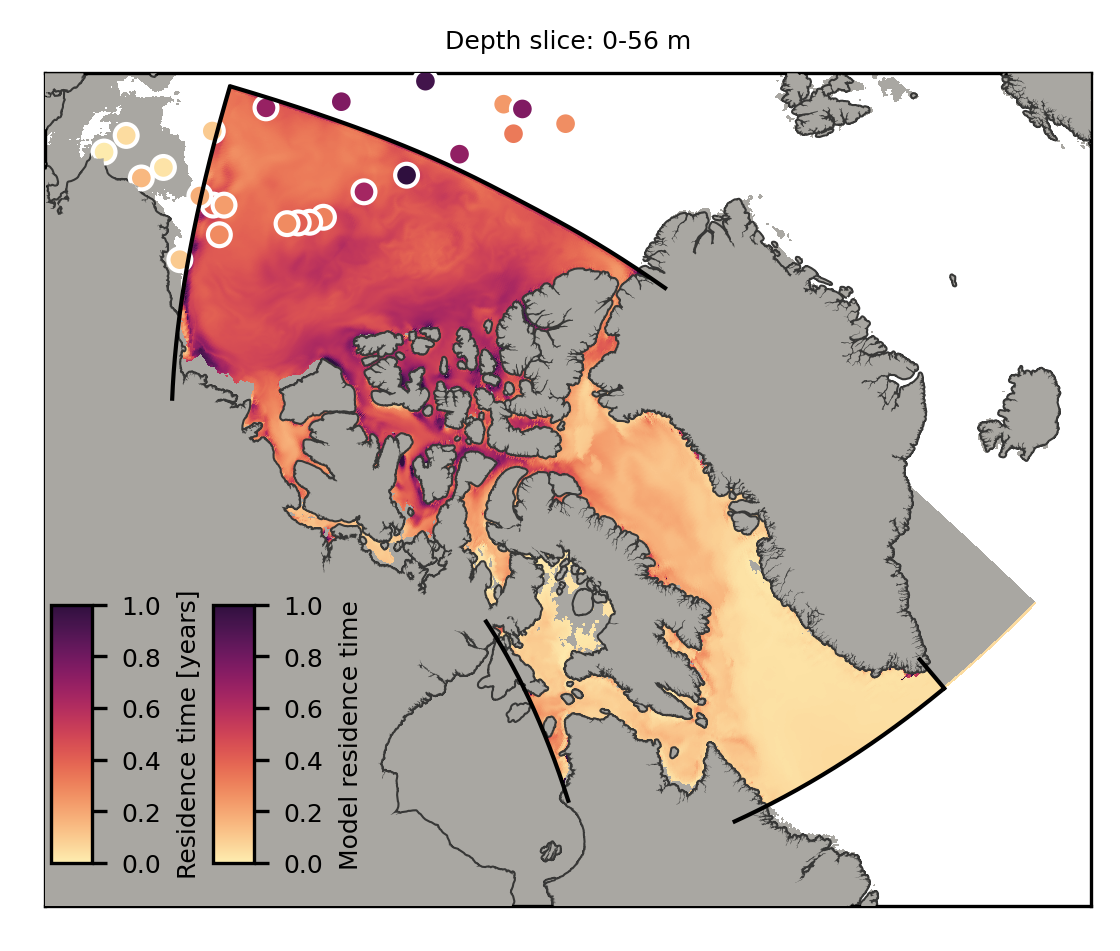

In [288]:
plot_residence_time(modelled_res_time, depth_slice=(0,18), maxv=1)

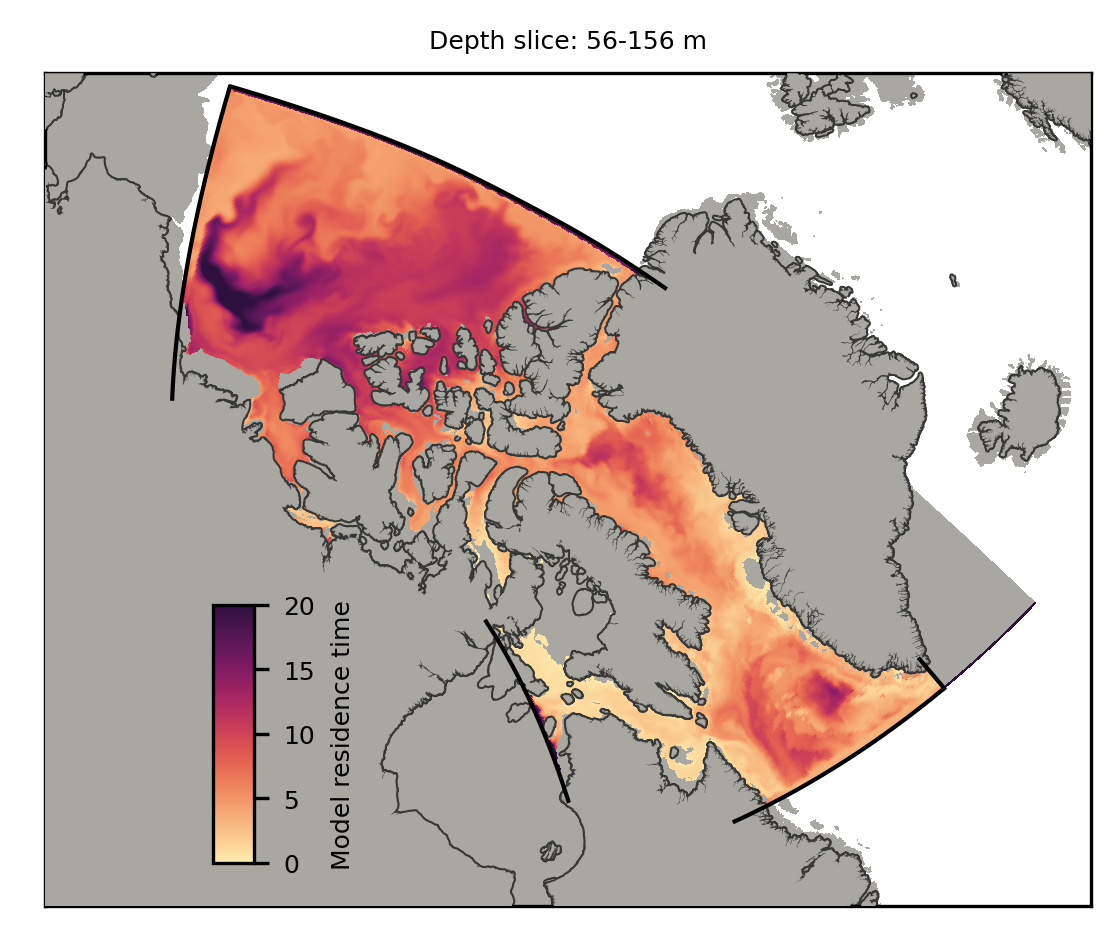

In [289]:
plot_residence_time(modelled_res_time, depth_slice=(18,24), maxv=20)

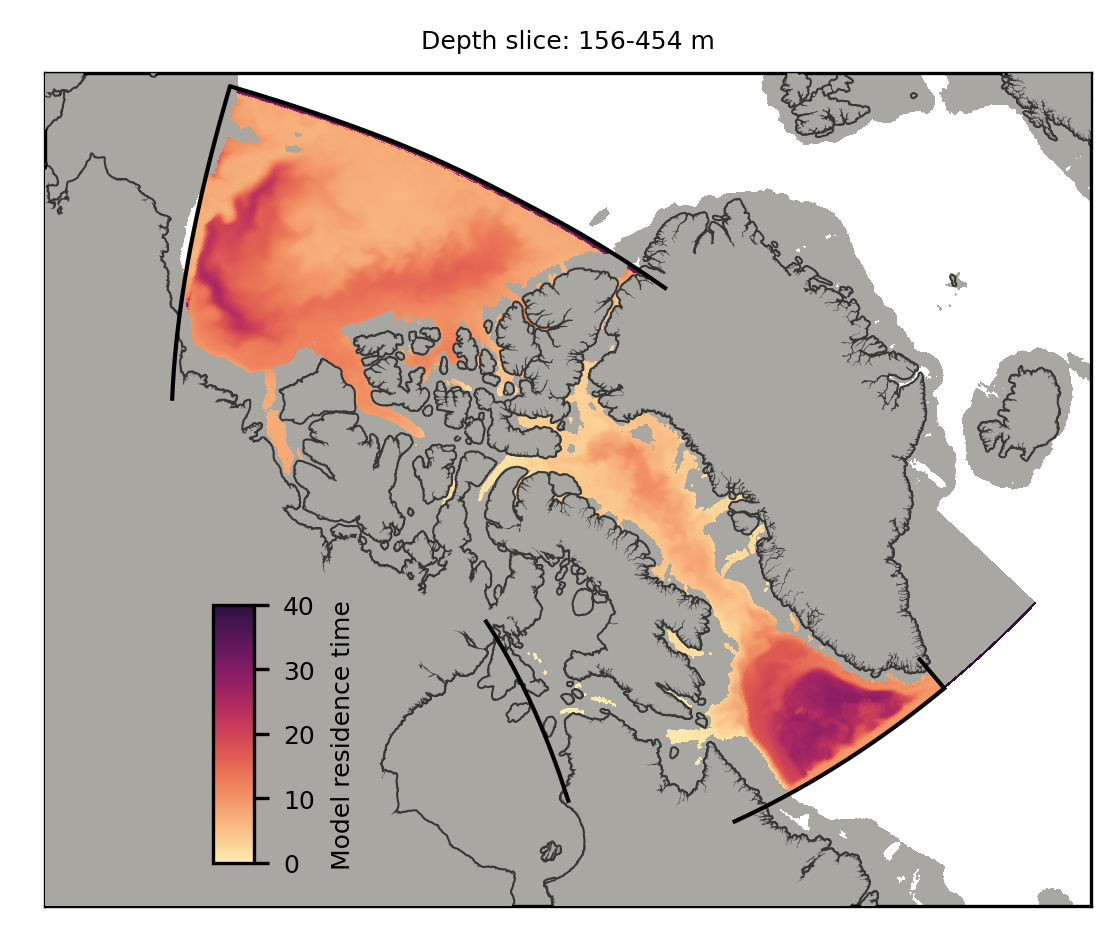

In [290]:
plot_residence_time(modelled_res_time, depth_slice=(24,30), maxv=40)

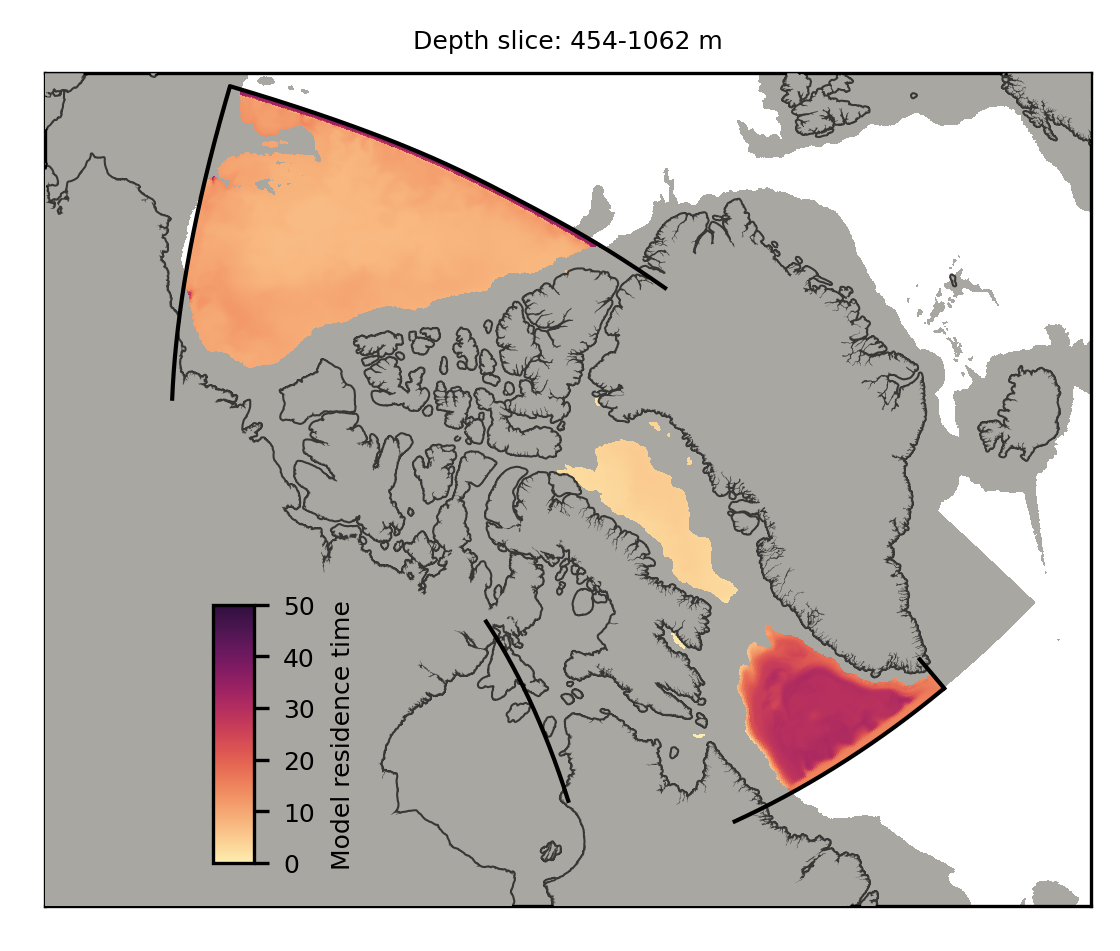

In [291]:
plot_residence_time(modelled_res_time, depth_slice=(30,35), maxv=50)

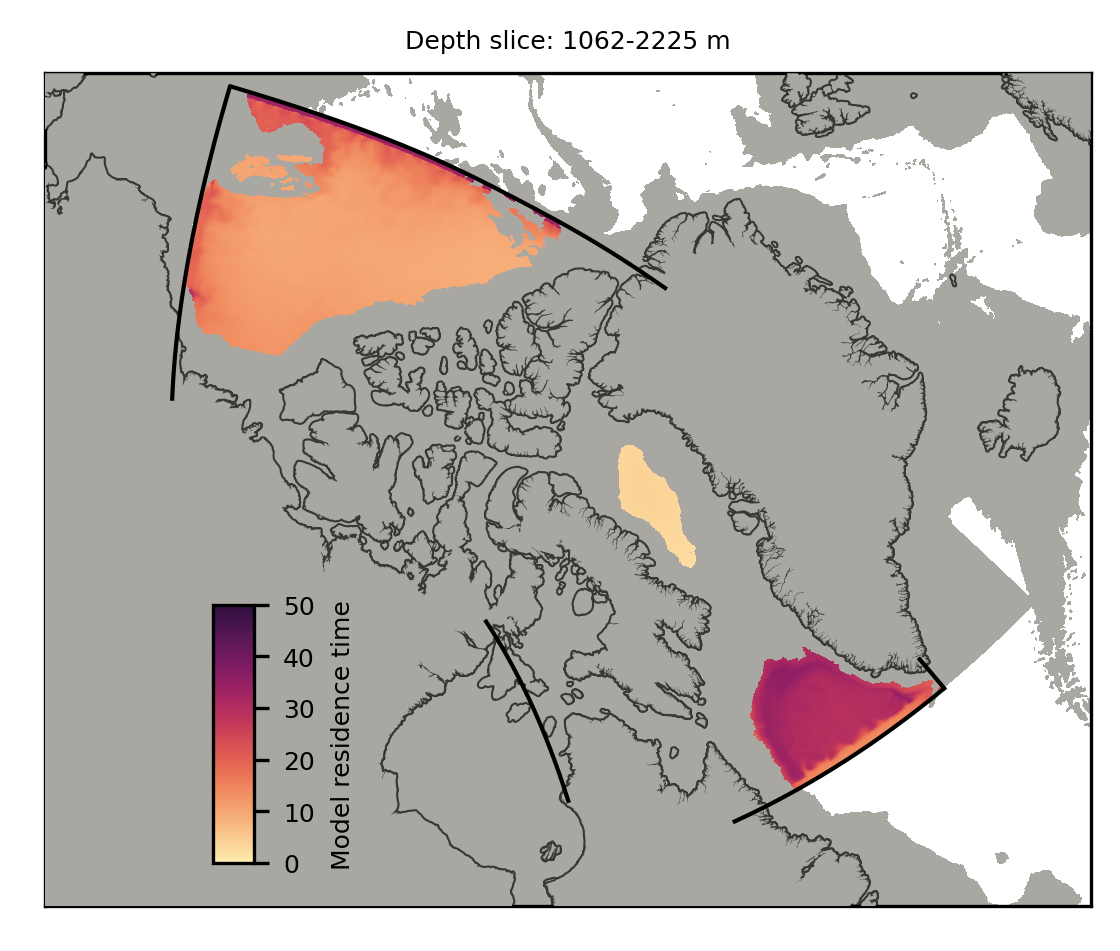

In [292]:
plot_residence_time(modelled_res_time, depth_slice=(35,40), maxv=50)

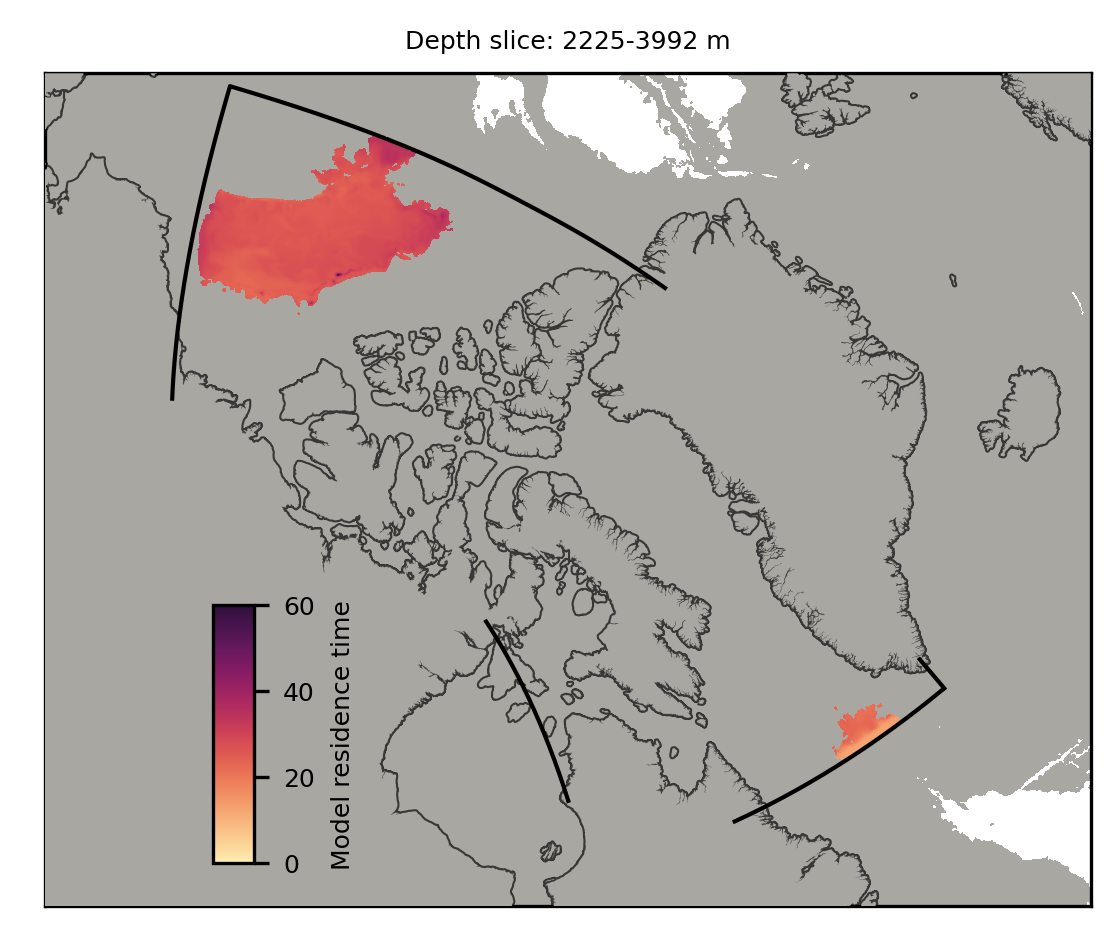

In [293]:
plot_residence_time(modelled_res_time, depth_slice=(40,45), maxv=60)

In [294]:
print(np.nanmax(modelled_res_time), np.nanmin(modelled_res_time))

800.0 0.005102130204244484


In [295]:
# Station in CB
# month=7
i  = 608
j  = 358
di = 30
dj = 30

modelled_res_time_ave     = np.nanmean(modelled_res_time[:,i-di:i+di,j-dj:j+dj],axis=(1,2))
normalized_biogenic_ave   = np.nanmean(normalized_biogenic[:,i-di:i+di,j-dj:j+dj],axis=(1,2))
normalized_lithogenic_ave = np.nanmean(normalized_lithogenic[:,i-di:i+di,j-dj:j+dj],axis=(1,2))

In [296]:
modelled_res_time_ave     = np.nanmean(modelled_res_time[:,:,:],axis=(1,2))

In [297]:
modelled_res_time_ave

array([ 0.05232423,  0.05289017,  0.05349913,  0.0540656 ,  0.05454033,
        0.05491614,  0.05511377,  0.05478075,  0.10216558,  0.13958306,
        0.17515933,  0.23055923,  0.31902447,  0.44644829,  0.62619073,
        0.93532529,  1.29621165,  1.82944386,  2.93082133,  4.43531448,
        6.85622113,  9.15563527, 11.18099594, 13.50556048, 14.56843573,
       14.47392668, 14.24413818, 13.87322422, 13.59650348, 13.54301371,
       14.10131918, 14.91573049, 11.56355274, 12.09426587, 12.58566517,
       13.02479033, 13.53703916, 14.27080245, 14.76048046, 15.23224426,
       16.12485626, 18.67129644, 23.59365345, 32.92838223, 47.7270819 ,
       48.48434703,         nan,         nan,         nan,         nan])

In [325]:
# Bacon et al., 1976: Atlantic Ocean
Bacon_depth   = [300, 4880, 5003, 3820, 4940, 4950, 4440] # marked by top and bottom of range
Bacon_restime = [2.3, 20, 21, 54, 93, 90, 60]

# Henderson and Maier-Reimer, 2002: North Atlantic
HMR_depth   = [75, 2000]
HMR_restime = [3, 30] 

# Moore and Smith, 1986: 
MS_depth   = [200, 1770]
MS_restime = [5, 21] 

# Ones with only surface, intermediate or deep defined:
sid_depth = [5, 1500, 3000]
craig_restime = [2, np.nan, 54] # Craig et al., 1973; Pacific Ocean
nozaki_restime = [1.7, 15, 100] # Nozaki et al., 1976, 1990; Pacific Ocean
schaul_restime = [1.6, np.nan, 50] # Schaule and Patterson, 1983; Sargasso Sea

(5000.0, 0.0)

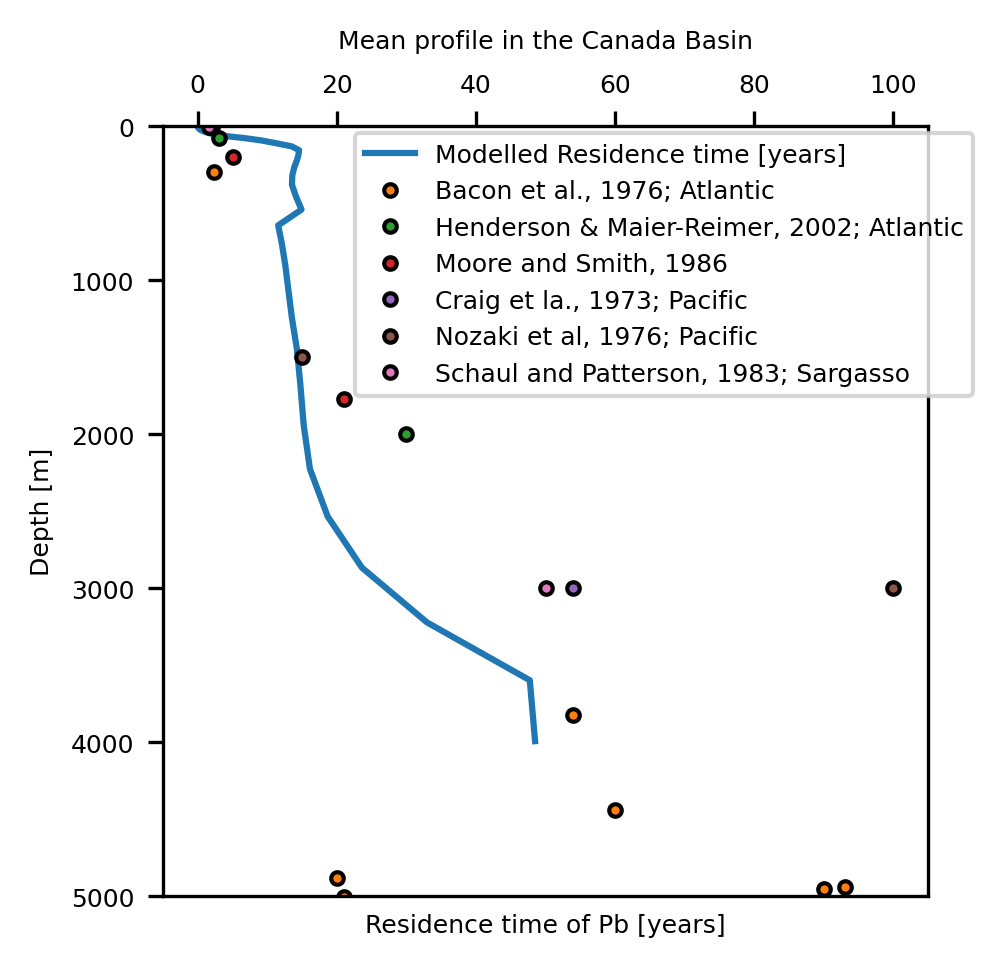

In [332]:
fig, ax = plt.subplots(1,1, figsize=(4.7*0.7,3.4), dpi=300)

ax.plot(modelled_res_time_ave, depths, label='Modelled Residence time [years]')
ax.plot(Bacon_restime, Bacon_depth,'.', markeredgecolor='k', \
        label='Bacon et al., 1976; Atlantic')
ax.plot(HMR_restime, HMR_depth,'.', markeredgecolor='k', \
        label='Henderson & Maier-Reimer, 2002; Atlantic')
ax.plot(MS_restime, MS_depth,'.', markeredgecolor='k', \
        label='Moore and Smith, 1986')
ax.plot(craig_restime,  sid_depth,'.', markeredgecolor='k', \
        label='Craig et la., 1973; Pacific')
ax.plot(nozaki_restime, sid_depth,'.', markeredgecolor='k', \
        label='Nozaki et al, 1976; Pacific')
ax.plot(schaul_restime, sid_depth,'.', markeredgecolor='k', \
        label='Schaul and Patterson, 1983; Sargasso')
# ax.plot(normalized_biogenic_ave*1e1, depths, color=colors[1], label='Biogenic')
# ax.plot(normalized_lithogenic_ave*1e1, depths, color=colors[2], label='Lithogenic')
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(labelsize=6)
ax.set_xlabel('Residence time of Pb [years]', fontsize=6)
ax.set_ylabel('Depth [m]', fontsize=6)
ax.set_title('Mean profile in the Canada Basin',fontsize=6)
ax.legend(loc=(0.25, 0.65), fontsize=6)
ax.set_ylim(5000,0)